# Compare Temperature Across Locations

Minimum and Maximum Temperature Comparison
* TMAX: The maximum temperature on a day between two locations
* TMIN: The minimum temperature on a day between two locations
* Boxenplot of daily TMAX or TMIN by month for one location

Mininum Temperature for Gardeners
* USDA Plant Hardiness Zones

The Ideal Temperature (Location)
* Based on TMAX

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import functions

## Minimum and Maximum Temperature Comparison

In [2]:
# # Station 1 - Clatskanie
# df = pd.read_csv('../data/temperature_97016.csv')
# df = df[df['STATION']=='USC00351643']
# df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
# df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)
# df1 = df[df['year']<2025]

# # Verify station 
# # functions.view_station_date_ranges(df)
# # geo_data = pd.read_csv('../data/geo_data.csv')
# # functions.map_stations(geo_data)

# assert len(df['STATION'].unique()) == 1

In [3]:
# Station 1 - Chicago
df = pd.read_csv('../data/temperature_chicago_ord.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)
df1 = df[df['year']<2025]
assert len(df['STATION'].unique()) == 1

In [4]:
# Station 2 - Portland
df = pd.read_csv('../data/temperature_97218.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)
df = df[df['year']<2025]
assert len(df['STATION'].unique()) == 1

df2 = df.copy()

In [5]:
# Merge the stations into one df
# df1_suffix = '_CLATSKANIE'
df1_suffix = '_ORD'
df2_suffix = '_PDX'
df = df1.merge(df2,
                on=['DATE', 'year'],
                how='inner',
                suffixes=(df1_suffix, df2_suffix)
)

In [6]:
# df.describe()
df

,STATION_ORD,NAME_ORD,DATE,TAVG_ORD,TMAX_ORD,TMIN_ORD,year,month_ORD,STATION_PDX,NAME_PDX,TAVG_PDX,TMAX_PDX,TMIN_PDX,month_PDX
0,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1947-01-01,11.0,NaN,NaN,1947,1,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,42,30,1
1,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1947-01-02,28.0,NaN,NaN,1947,1,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,42,27,1
2,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1947-01-03,22.0,NaN,NaN,1947,1,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,40,28,1
3,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1947-01-04,7.0,NaN,NaN,1947,1,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,38,21,1
4,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1947-01-05,5.0,NaN,NaN,1947,1,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",NaN,37,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28481,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",2024-12-27,47.0,52.0,45.0,2024,12,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",49.0,53,45,12
28482,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",2024-12-28,50.0,51.0,42.0,2024,12,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",51.0,55,48,12
28483,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",2024-12-29,44.0,46.0,36.0,2024,12,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",49.0,52,43,12
28484,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",2024-12-30,37.0,42.0,32.0,2024,12,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",45.0,50,41,12


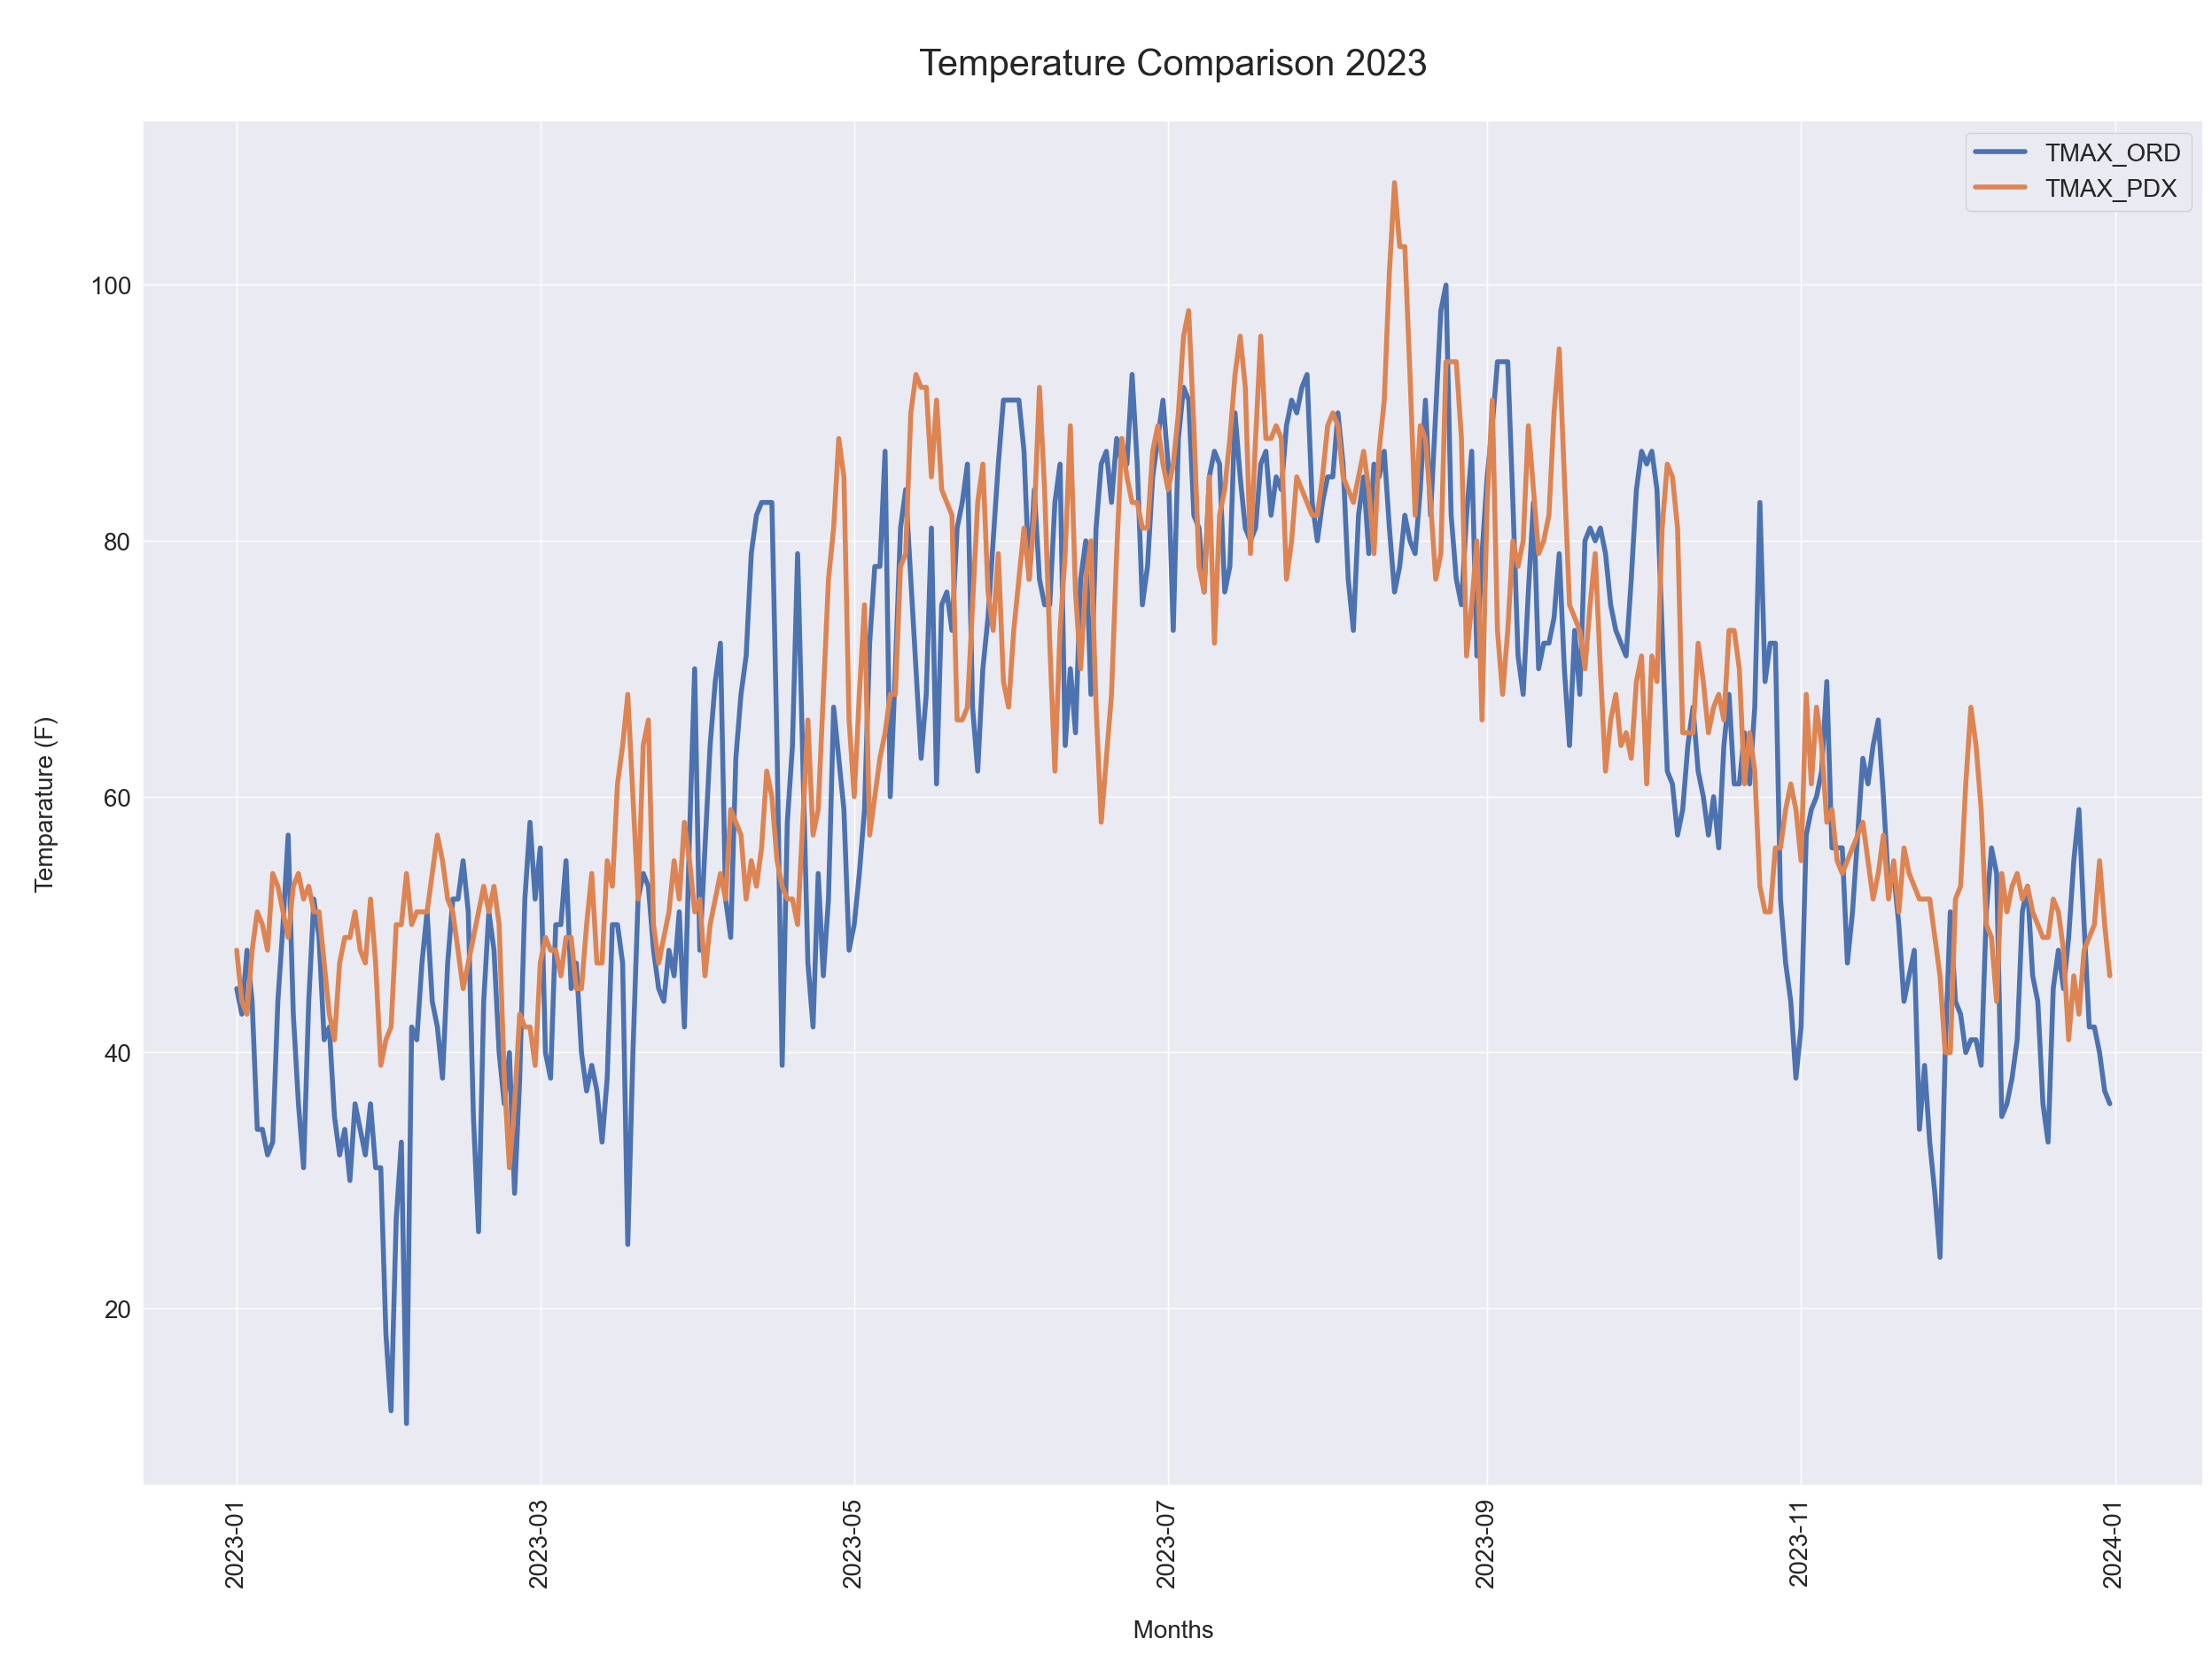

In [7]:
# Plot maximum temperature
pmax = functions.plot_temp_compare(df, 'TMAX', 2023)
# pmax.savefig('tmax_compare.jpg') 

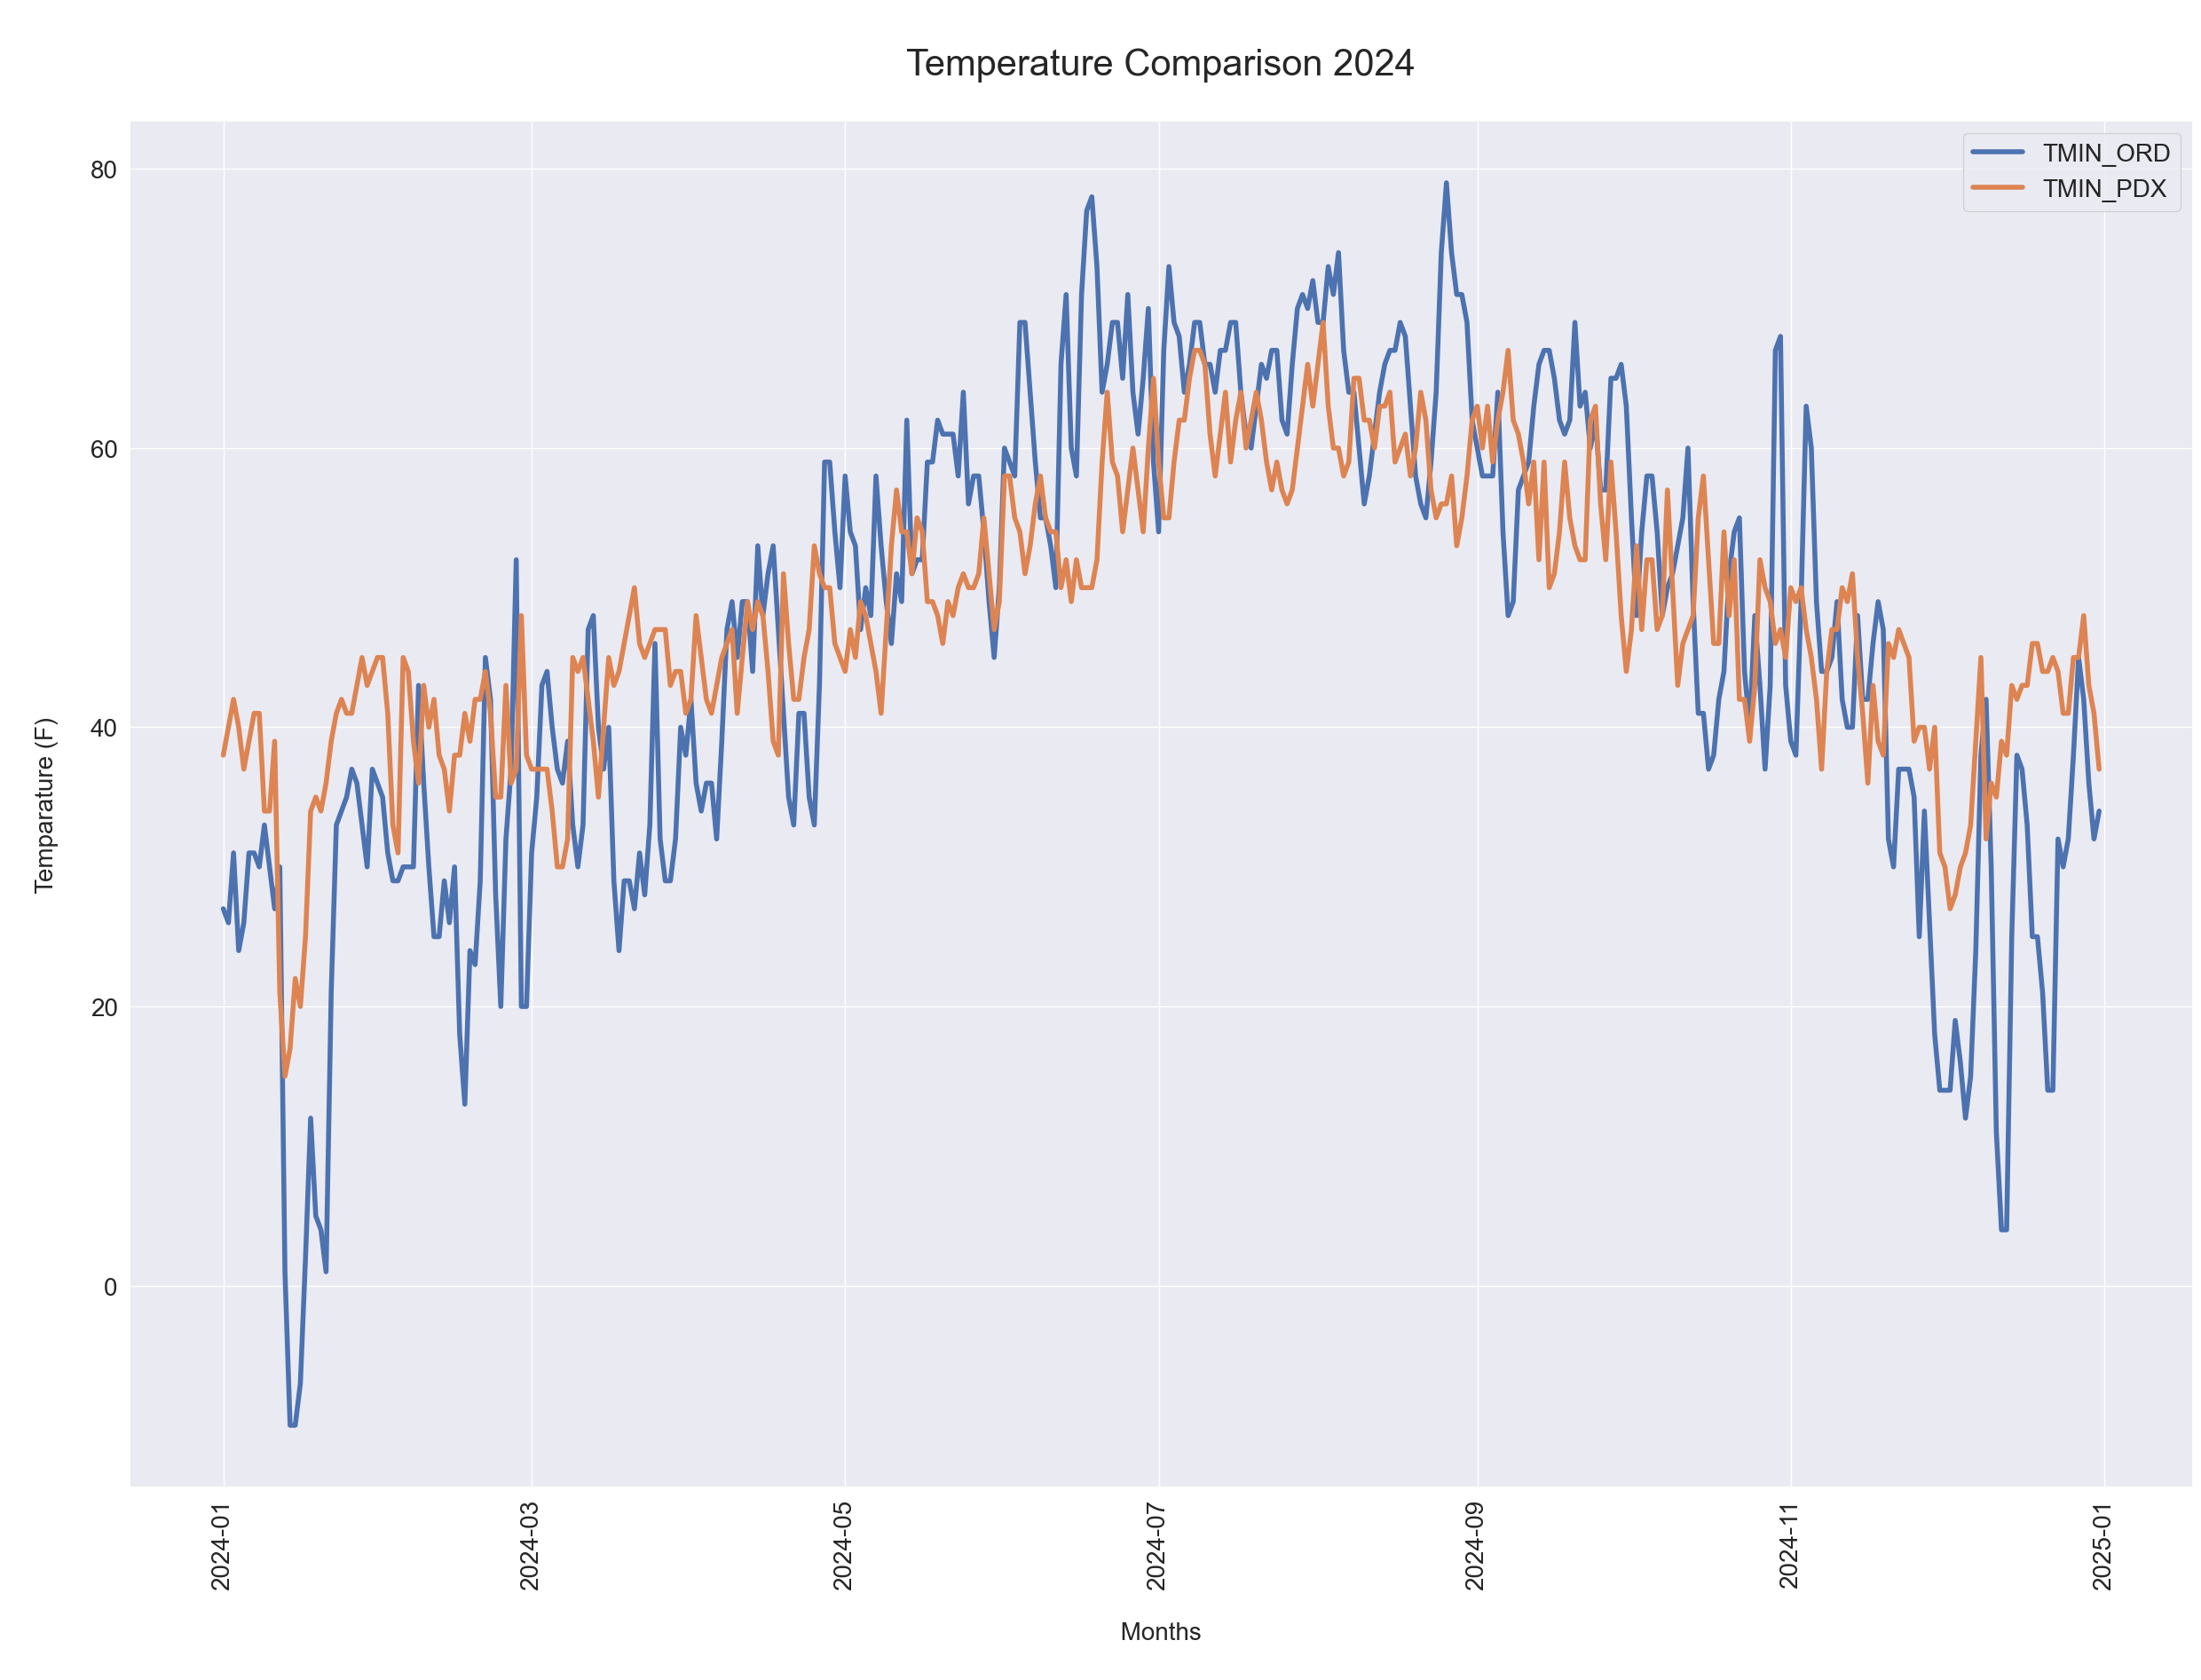

In [8]:
# Plot minimum temperature
pmin = functions.plot_temp_compare(df, 'TMIN', 2024)
# pmin.savefig('tmin_compare.jpg') 

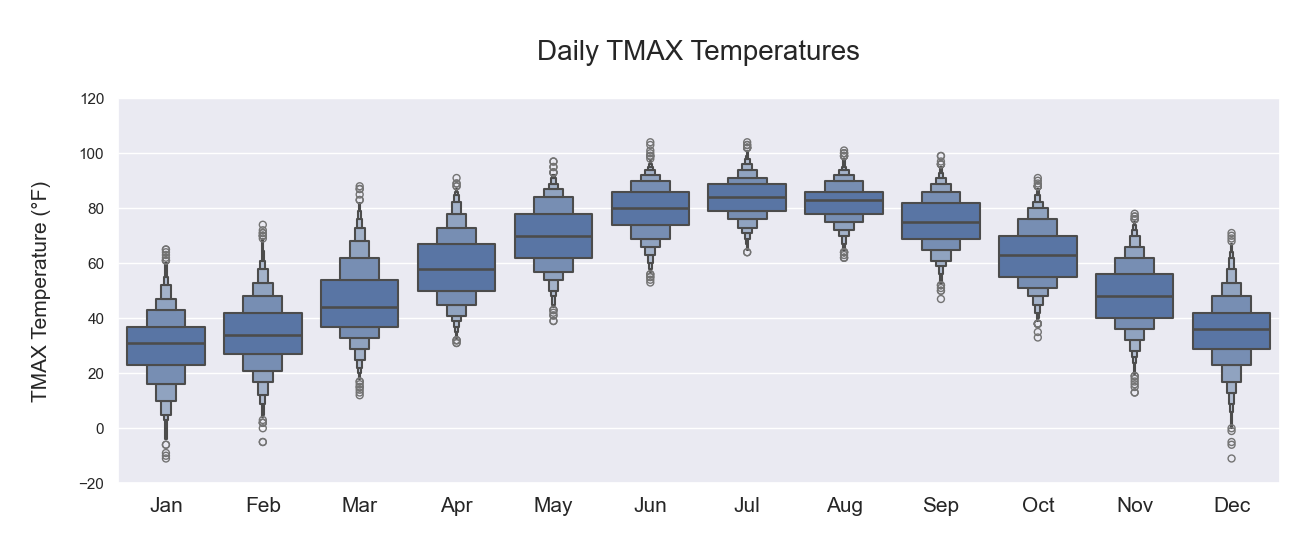

In [9]:
functions.plot_monthly_temp_plots(df1, metric='TMAX', ylim_low=-20, ylim_high=120)

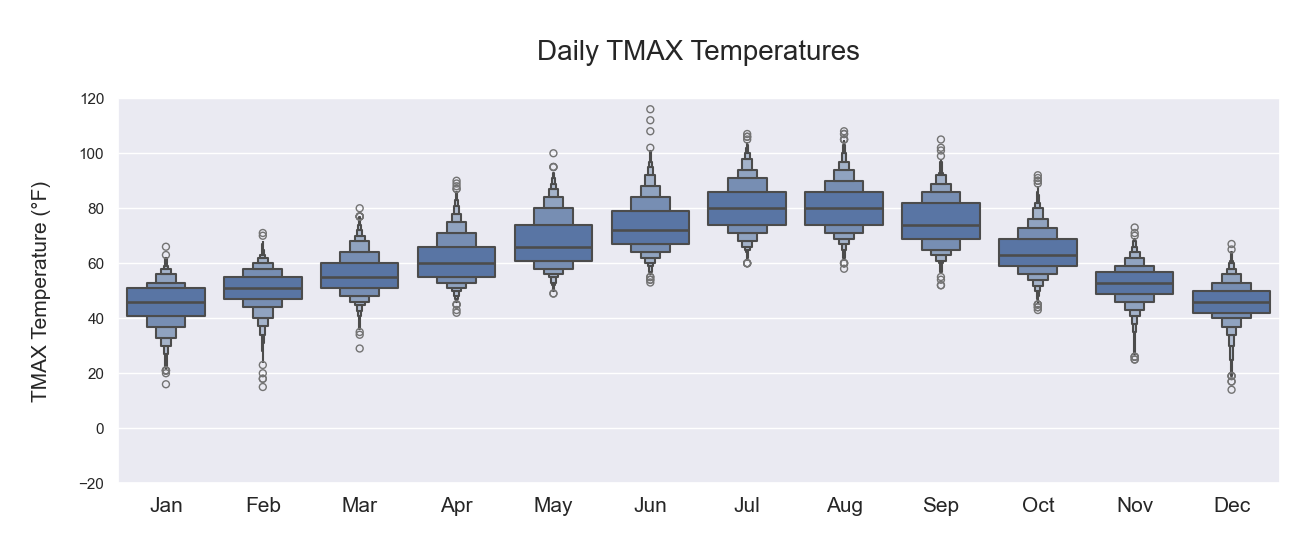

In [10]:
functions.plot_monthly_temp_plots(df2, metric='TMAX', ylim_low=-20, ylim_high=120)

## USDA Plant Hardiness Zones

A USDA hardiness zone is defined by the minimum annual temperature at a station, averaged over the last 30 years.  For example, by this metric:
* USDA Zone 8a falls within 10°F and 15°F
* USDA Zone 8b falls within 15°F and 20°F
* USDA Zone 9a falls within 20°F and 25°F


In [11]:
# TODO move the following into functions once done testing and scaling

In [19]:
# Get Daily Minimum Temperature data
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df1 = df[df['STATION']=='USC00351643']

df2 = pd.read_csv('../data/temperature_chicago_ord.csv')
df2 = df2.assign(year = pd.to_datetime(df2['DATE']).dt.year)

df3 = pd.read_csv('../data/temperature_97218.csv')
df3 = df3.assign(year = pd.to_datetime(df3['DATE']).dt.year)

df4 = pd.read_csv('../data/temperature_tampa_tpa.csv')
df4 = df4.assign(year = pd.to_datetime(df4['DATE']).dt.year)

# Verify that there is only one station per df
assert len(df1.STATION.unique()) == 1
assert len(df2.STATION.unique()) == 1
assert len(df3.STATION.unique()) == 1
assert len(df4.STATION.unique()) == 1

In [21]:
# Merge the stations into one df
df = pd.concat([df1, df2, df3, df4])
# df = pd.concat([df1, df2])
df


,STATION,NAME,DATE,TAVG,TMAX,TMIN,year
25291,USC00351643,"CLATSKANIE, OR US",1935-05-01,NaN,60.0,40.0,1935
25292,USC00351643,"CLATSKANIE, OR US",1935-05-02,NaN,67.0,36.0,1935
25293,USC00351643,"CLATSKANIE, OR US",1935-05-03,NaN,75.0,40.0,1935
25294,USC00351643,"CLATSKANIE, OR US",1935-05-04,NaN,74.0,41.0,1935
25295,USC00351643,"CLATSKANIE, OR US",1935-05-05,NaN,61.0,49.0,1935
...,...,...,...,...,...,...,...
31042,USW00012842,"TAMPA INTERNATIONAL AIRPORT, FL US",2024-12-27,69.0,80.0,63.0,2024
31043,USW00012842,"TAMPA INTERNATIONAL AIRPORT, FL US",2024-12-28,72.0,79.0,67.0,2024
31044,USW00012842,"TAMPA INTERNATIONAL AIRPORT, FL US",2024-12-29,72.0,79.0,68.0,2024
31045,USW00012842,"TAMPA INTERNATIONAL AIRPORT, FL US",2024-12-30,70.0,77.0,66.0,2024


In [23]:
# Get weather station location data 
df_stations = pd.read_csv('../data/geo_data.csv')
# df_stations = df_stations[df_stations['STATION'].isin(list(set(df1['STATION'].unique()).union(df2['STATION'].unique())))]
df_stations = df_stations[df_stations['STATION'].isin(df['STATION'].unique())]

# Map the stations 
# US
functions.map_stations(df_stations,
                       default_lat=40,
                       default_long=-95,
                       default_zoom=4,)

# # Oregon
# functions.map_stations(df_stations,
#                        default_lat=45.7,
#                        default_long=-122.7,
#                        default_zoom=9,)

In [24]:
# Pivot df to see the minimum temperature by year for each station
tmin = df.pivot_table(index='year', columns='NAME', values='TMIN', aggfunc='min').reset_index()

# Check for null values
print('null values', tmin.isnull().sum().sum())

tmin

null values 33


NAME,year,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US","CLATSKANIE, OR US","PORTLAND INTERNATIONAL AIRPORT, OR US","TAMPA INTERNATIONAL AIRPORT, FL US"
0,1935,NaN,19.0,NaN,NaN
1,1936,NaN,19.0,NaN,NaN
2,1937,NaN,9.0,NaN,NaN
3,1938,NaN,21.0,NaN,NaN
4,1939,NaN,23.0,NaN,NaN
...,...,...,...,...,...
85,2020,-2.0,24.0,27.0,36.0
86,2021,-7.0,21.0,24.0,42.0
87,2022,-8.0,20.0,20.0,31.0
88,2023,-1.0,16.0,18.0,40.0


In [25]:
# Calculate the USDA hardiness zone for each station and year for all columns except the first (year)
for col in tmin.columns[1:]:
    zone_col = f"{col.replace('TMIN_', '').replace('_', ' ')} Hardiness Zone"
    tmin[zone_col] = tmin[col].rolling(window=30, min_periods=30).mean()
tmin


NAME,year,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US","CLATSKANIE, OR US","PORTLAND INTERNATIONAL AIRPORT, OR US","TAMPA INTERNATIONAL AIRPORT, FL US","CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Hardiness Zone","CLATSKANIE, OR US Hardiness Zone","PORTLAND INTERNATIONAL AIRPORT, OR US Hardiness Zone","TAMPA INTERNATIONAL AIRPORT, FL US Hardiness Zone"
0,1935,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1936,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1937,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1938,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1939,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
85,2020,-2.0,24.0,27.0,36.0,-8.466667,16.666667,20.766667,32.800000
86,2021,-7.0,21.0,24.0,42.0,-8.600000,16.766667,20.900000,33.100000
87,2022,-8.0,20.0,20.0,31.0,-8.466667,16.733333,20.666667,32.933333
88,2023,-1.0,16.0,18.0,40.0,-8.333333,16.866667,20.666667,33.100000


In [26]:
# Store the number of stations
n = len(df['STATION'].unique())

# Create a list of the column names for all_locations
all_locations = list(tmin.columns[1:n+1])
all_locations

['CHICAGO OHARE INTERNATIONAL AIRPORT, IL US',
 'CLATSKANIE, OR US',
 'PORTLAND INTERNATIONAL AIRPORT, OR US',
 'TAMPA INTERNATIONAL AIRPORT, FL US']

In [27]:
# Make the wide format long, for the seaborn lineplot
tmin_long = tmin.reset_index().melt(id_vars='year', value_vars=all_locations,
                      var_name='station', value_name='tmin')
tmin_long

,year,station,tmin
0,1935,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN
1,1936,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN
2,1937,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN
3,1938,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN
4,1939,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN
...,...,...,...
355,2020,"TAMPA INTERNATIONAL AIRPORT, FL US",36.0
356,2021,"TAMPA INTERNATIONAL AIRPORT, FL US",42.0
357,2022,"TAMPA INTERNATIONAL AIRPORT, FL US",31.0
358,2023,"TAMPA INTERNATIONAL AIRPORT, FL US",40.0


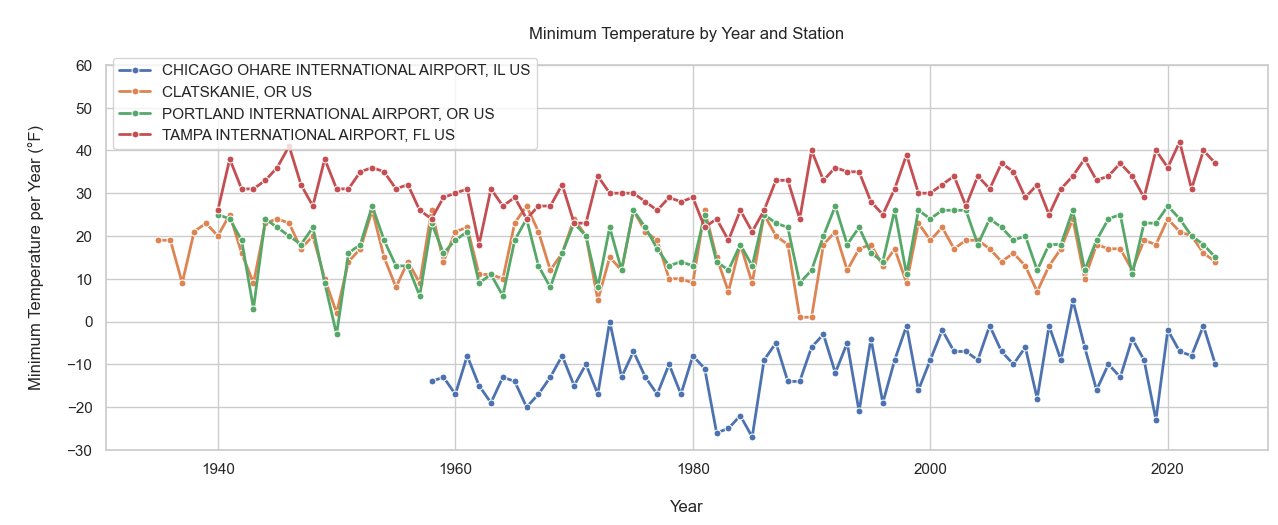

In [29]:
sns.set_theme(style="whitegrid")
# sns.set_theme(style="darkgrid")
# plt.style.use('dark_background')
plt.figure(figsize=(15, 5))
p = sns.lineplot(data=tmin_long,
             x='year',
             y='tmin',
             hue='station',
            #  palette=['green', 'orange', 'blue'],
             marker='o',    
             markersize=5,
             linewidth=2,
             style='station',
             dashes=False,
            #  legend='full',
                )

# add a title to the plot
plt.title('\nMinimum Temperature by Year and Station\n')
plt.ylim(-30, 60)
p.set_xlabel("\nYear", fontsize=12, rotation=0)
p.set_ylabel("\nMinimum Temperature per Year (°F)\n", fontsize=12, rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.9))

# Suppress printouts
plt.show()

In [30]:
# Make the wide format long, for the seaborn lineplot
usdahz = tmin.reset_index().melt(id_vars='year', value_vars=list(tmin.columns[n+1:]),
                      var_name='station', value_name='USDA Hardiness Zone').dropna()
usdahz

,year,station,USDA Hardiness Zone
52,1987,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Har...",-14.100000
53,1988,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Har...",-14.100000
54,1989,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Har...",-14.133333
55,1990,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Har...",-13.766667
56,1991,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US Har...",-13.600000
...,...,...,...
355,2020,"TAMPA INTERNATIONAL AIRPORT, FL US Hardiness Zone",32.800000
356,2021,"TAMPA INTERNATIONAL AIRPORT, FL US Hardiness Zone",33.100000
357,2022,"TAMPA INTERNATIONAL AIRPORT, FL US Hardiness Zone",32.933333
358,2023,"TAMPA INTERNATIONAL AIRPORT, FL US Hardiness Zone",33.100000


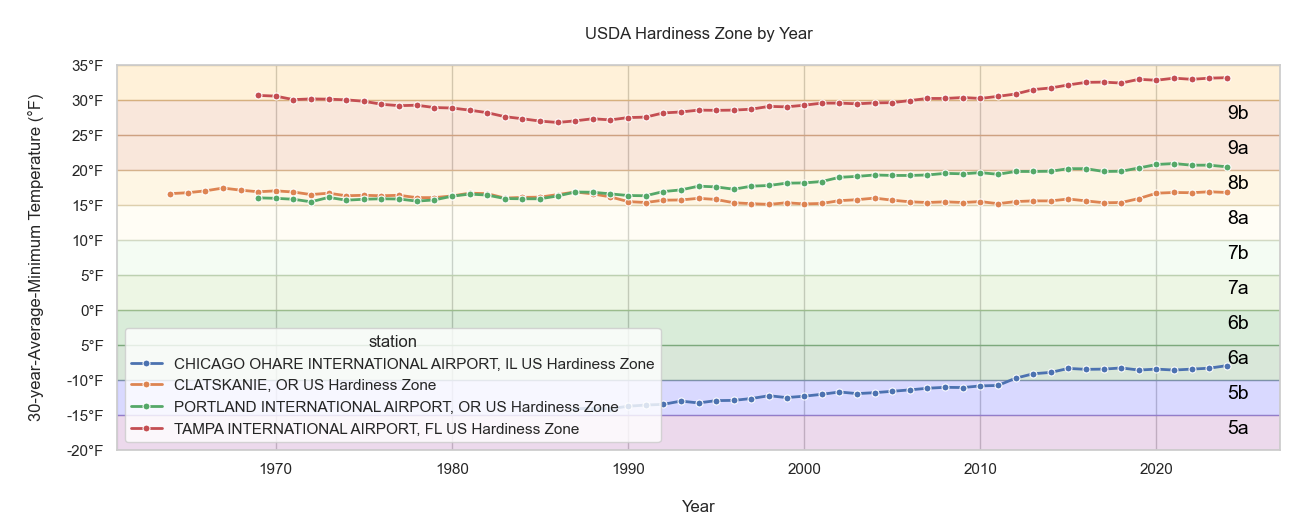

In [41]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,5))
p = sns.lineplot(data=usdahz,
             x='year',
             y='USDA Hardiness Zone',
             hue='station',
            #  palette=['green', 'blue', 'orange'],
             marker='o',    
             markersize=5,
             linewidth=2,
             style='station',
             dashes=False,
                )

# Superimpose colored bands for USDA zones
# https://colorbrewer2.org/#type=sequential&scheme=YlOrBr&n=3
p.axhspan(-20, -15, color='purple', alpha=0.15, label='Zone 5a (-20 to -15°F)')
p.axhspan(-15, -10, color='blue', alpha=0.15, label='Zone 5b (-15 to -10°F)')
p.axhspan(-10, -5, color='#006400', alpha=0.15, label='Zone 6a (-10 to -5°F)')
p.axhspan(-5, 0, color='green', alpha=0.15, label='Zone 6b (-5 to 0°F)')
p.axhspan(0, 5, color='#8bc34a', alpha=0.15, label='Zone 7a (0 to 5°F)')
p.axhspan(5, 10, color='#b7efb2', alpha=0.15, label='Zone 7b (5 to 10°F)')
p.axhspan(10, 15, color='#fff7bc', alpha=0.15, label='Zone 8a (10 to 15°F)')
p.axhspan(15, 20, color='#fec44f', alpha=0.15, label='Zone 8b (15 to 20°F)')
p.axhspan(20, 25, color='#d95f0e', alpha=0.15, label='Zone 9a (20 to 25°F)')
p.axhspan(25, 30, color='#d95f0e', alpha=0.15, label='Zone 9b (25 to 30°F)')
p.axhspan(30, 35, color='orange', alpha=0.15, label='Zone 10a (30 to 35°F)')

# Add zone labels
year_label = 2024
p.text(x=year_label, y=-17, s='5a', color='black', fontsize=14, va='center')
p.text(x=year_label, y=-12, s='5b', color='black', fontsize=14, va='center')
p.text(x=year_label, y=-7, s='6a', color='black', fontsize=14, va='center')
p.text(x=year_label, y=-2, s='6b', color='black', fontsize=14, va='center')
p.text(x=year_label, y=3, s='7a', color='black', fontsize=14, va='center')
p.text(x=year_label, y=8, s='7b', color='black', fontsize=14, va='center')
p.text(x=year_label, y=13, s='8a', color='black', fontsize=14, va='center')
p.text(year_label, 18, '8b', color='black', fontsize=14, va='center')
p.text(year_label, 23, '9a', color='black', fontsize=14, va='center')
p.text(year_label, 28, '9b', color='black', fontsize=14, va='center')

plt.title('\nUSDA Hardiness Zone by Year\n')
plt.ylim(-20, 35)
p.set_yticks(np.arange(-20, 36, 5))
p.set_yticklabels(['-20°F', '-15°F', '-10°F', '5°F', '0°F', '5°F', '10°F', '15°F',
                    '20°F', '25°F', '30°F', '35°F'])
p.set_xlabel("\nYear", fontsize=12, rotation=0)
p.set_ylabel("\n30-year-Average-Minimum Temperature (°F)\n", fontsize=12, rotation=90)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## The Ideal Temperature
* A TMAX comparison between two locations

In [95]:
# Get Daily Maximum Temperature data
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df.assign(month = pd.to_datetime(df['DATE']).dt.month)
df1 = df[df['STATION']=='USC00351643']
# df2 = pd.read_csv('../data/temperature_chicago_ord.csv')
df2 = pd.read_csv('../data/temperature_97218.csv')
df2 = df2.assign(year = pd.to_datetime(df2['DATE']).dt.year)
df2 = df2.assign(month = pd.to_datetime(df2['DATE']).dt.month)

# Verify that there is only one station per df
assert len(df1.STATION.unique()) == 1
assert len(df2.STATION.unique()) == 1

# Merge the stations into one df
df1_suffix = '_CLATSKANIE'
df2_suffix = '_PDX'
# df2_suffix = '_ORD'
df = df1.merge(df2,
          on=['DATE', 'year'],
          how='inner',
          suffixes=(df1_suffix, df2_suffix)
          ).drop(['STATION' + df1_suffix, 'STATION' + df2_suffix], axis=1)

In [96]:
# Collect data for bar plots with the output of this function 
great_days = functions.ideal_tmax(df, 60, 80).head(5).sort_values(by='year', ascending=True)
fine_days = functions.ideal_tmax(df, 50, 85).head(5).sort_values(by='year', ascending=True)
okay_days = functions.ideal_tmax(df, 40, 85).head(5).sort_values(by='year', ascending=True)

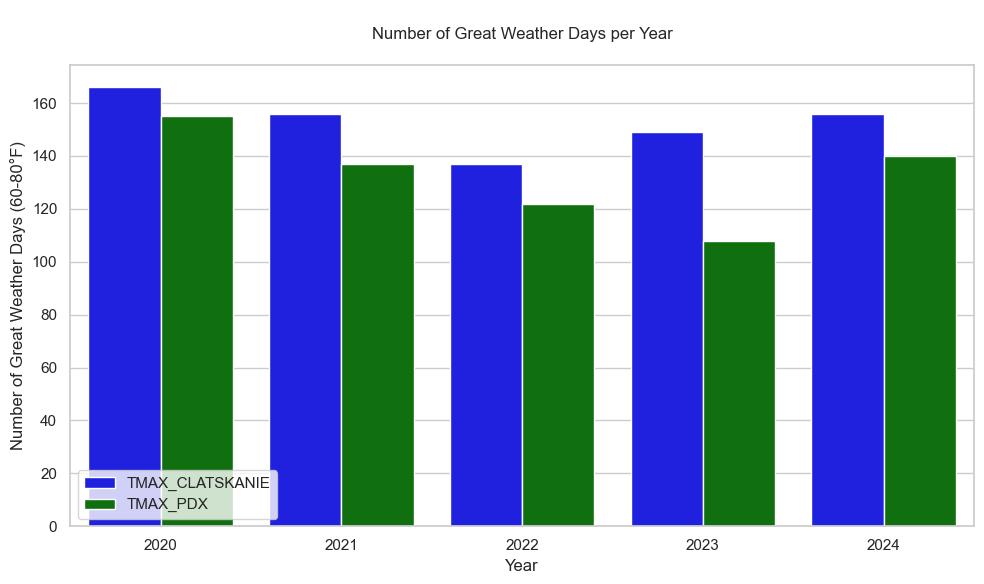

In [97]:
# Prepare data for seaborn barplot
great_days_long = great_days.melt(id_vars='year', value_vars=[df.columns[3], df.columns[9]],
                                 var_name='Station', value_name='Great Weather Days')

plt.figure(figsize=(10, 6))
sns.barplot(data=great_days_long, x='year', y='Great Weather Days', hue='Station', palette=['blue', 'green'])
plt.xlabel('Year')
plt.ylabel('Number of Great Weather Days (60-80°F)')
plt.title('\nNumber of Great Weather Days per Year\n')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

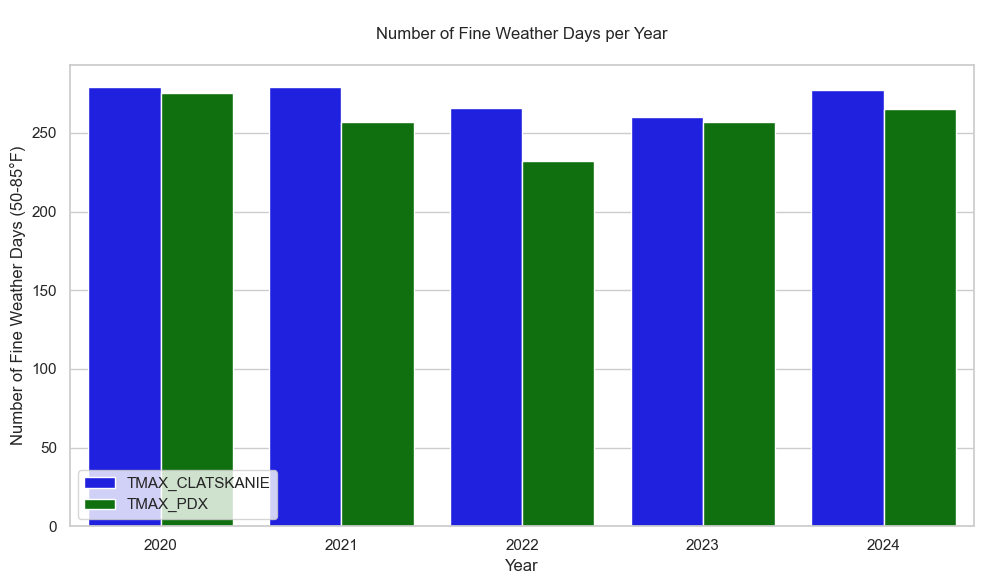

In [98]:
# Prepare data for seaborn barplot
fine_days_long = fine_days.melt(id_vars='year', value_vars=[df.columns[3], df.columns[9]],
                                 var_name='Station', value_name='Fine Weather Days')

plt.figure(figsize=(10, 6))
sns.barplot(data=fine_days_long, x='year', y='Fine Weather Days', hue='Station', palette=['blue', 'green'])
plt.xlabel('Year')
plt.ylabel('Number of Fine Weather Days (50-85°F)')
plt.title('\nNumber of Fine Weather Days per Year\n')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

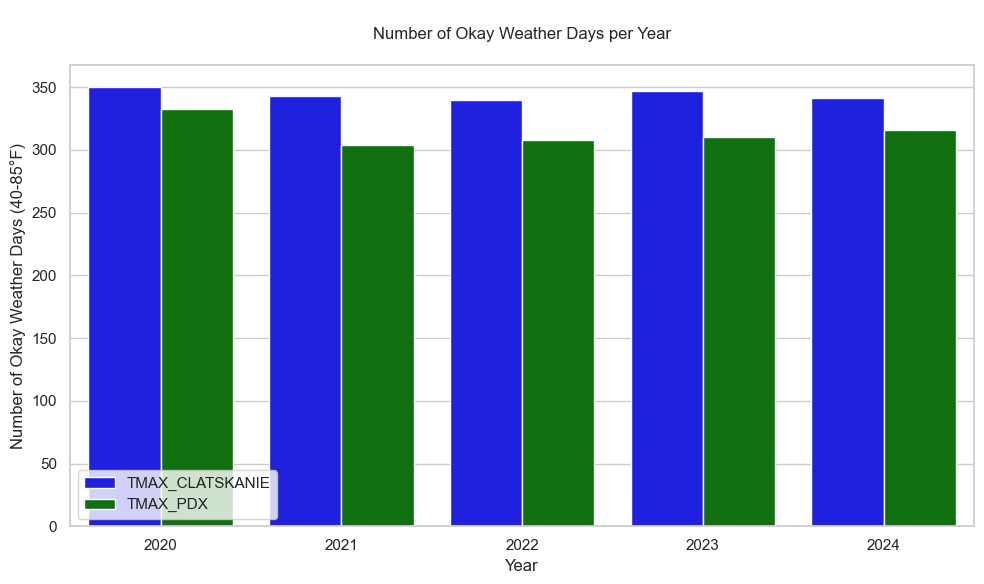

In [99]:
# create the same seaborn plot for okay_days
okay_days_long = okay_days.melt(id_vars='year', value_vars=[df.columns[3], df.columns[9]],
                               var_name='Station', value_name='Okay Weather Days')

plt.figure(figsize=(10, 6))
sns.barplot(data=okay_days_long, x='year', y='Okay Weather Days', hue='Station', palette=['blue', 'green'])
plt.xlabel('Year')
plt.ylabel('Number of Okay Weather Days (40-85°F)')
plt.title('\nNumber of Okay Weather Days per Year\n')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()